<a href="https://colab.research.google.com/github/Calcifer777/learn-deep-learning/blob/main/learn-rag/faiss_ops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources

- Index factory docs: https://github.com/facebookresearch/faiss/wiki/The-index-factory
- How to navigate the 'index_factory': https://www.pinecone.io/learn/series/faiss/composite-indexes/
- https://www.pinecone.io/learn/series/faiss/

In [1]:
%%bash

pip install faiss-cpu faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.3 MB/s eta 0:00:00


In [2]:
import os
import time

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

import faiss

## Parameters

In [3]:
vector_dim = 64

# only for IVF indexes
n_probes = 8
n_centroids = 64

# only for PQ indexes
n_groups = 16  # must be divisible by vector dim
bits = 8  # bits in each centroid

# FAISS Indices

## Flat index

Measures the L2 (or Euclidean) distance between all given points between our query vector, and the vectors loaded into the index. It’s simple, **very accurate, but not too fast**.

## Locality Sensitive Index

Locality Sensitive Hashing (LSH) works by grouping vectors into buckets by processing each vector through a hash function that maximizes hashing collisions — rather than minimizing as is usual with hashing functions.

IndexLSH is not suitable if we have large vector dimensionality (128 is already too large). Instead, it is best suited to low-dimensionality vectors — and small indexes.

## HNSW

Where RAM is not a limiting factor HNSW is great as a well-balanced index that we can push to focus more towards quality by increasing our three parameters

## Inverted File indexes

The quantizer (an Index instance) provides a quantization index for each vector to be added. The quantization index maps to a list (aka inverted list or posting list), where the id of the vector is stored.

At search time, the vector to be searched is also quantized, and only the list corresponding to the quantization index is searched. This **speeds up the search by making it non-exhaustive**. This **can be relaxed using multi-probe** search.

### IVFFlat

Inverted file with stored vectors. Here the inverted file pre-selects the vectors to be searched, but they are not otherwise encoded, the code array just contains the raw float entries.


### IVFPQ

Inverted file with Product Quantizer encoding. Each residual vector is encoded as a product quantizer code.

## Product Quantization

Where IVF allows us to approximate by reducing the scope of our search, PQ approximates the distance/similarity calculation instead.

- Split the original vector into several subvectors.
- For each set of subvectors, we perform a clustering operation — creating multiple centroids for each sub-vector set.
- In our vector of sub-vectors, we replace each sub-vector with the ID of it’s nearest set-specific centroid.

- Very high recall is out of reach for both PQ and IVFPQ indexes


In [9]:
flat_index = faiss.index_factory(vector_dim, "Flat")

ivf_index = faiss.index_factory(vector_dim, f"IVF{n_centroids},Flat")

quantizer = faiss.IndexFlatL2(vector_dim)
ivfpq_index = faiss.IndexIVFPQ(quantizer, vector_dim, n_centroids, n_groups, bits)
ivfpq_index.nprobe = n_probes

In [12]:
indexes = dict(
    flat=flat_index,
    ivf=ivf_index,
    ivfpq=ivfpq_index,
)

# Query times

In [10]:
def fill_index(index: faiss.Index, n: int, dim: int):
    index.reset()
    corpus = np.random.rand(n, dim)
    if index.is_trained is False:
        index.train(corpus)
    index.add(corpus)
    assert index.is_trained is True
    assert index.ntotal == n

In [27]:
def get_query_times(
    index: faiss.Index,
    step: int = 100_000,
    max_corpus_size: int =  5_000_000,
    dim: int = vector_dim,
    n_queries: int = 10,
    q_tries: int = 5,
    n_results: int = 10,
) -> tuple[list[int], list[int]]:
    corpus_sizes = range(step, max_corpus_size + step, step)
    times = []

    pbar = tqdm(corpus_sizes)
    for n in pbar:
        fill_index(index, n, dim)
        q_times = []
        for i in range(q_tries):
            queries = np.random.rand(n_queries, dim)
            start = time.perf_counter()
            _, _ = index.search(queries, k=n_results)
            q_times.append(time.perf_counter() - start)
        times.append(np.mean(q_times) * 1_000)
        index.reset()

    return corpus_sizes, times

In [28]:
query_times = dict()

for index_name, index in indexes.items():
    query_times[index_name] = get_query_times(index)

100%|██████████| 50/50 [12:06<00:00, 14.53s/it]


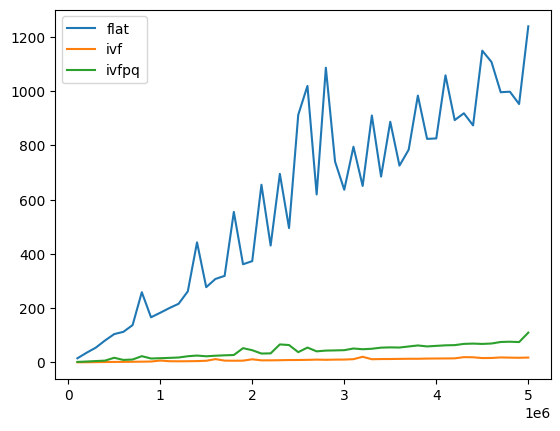

In [29]:
for index_name, (corpus_sizes, times) in query_times.items():
    plt.plot(corpus_sizes, times)
plt.legend(query_times.keys())

# Memory Usage

In [6]:
def get_memory(index):
    # write index to file
    faiss.write_index(index, './temp.index')
    # get file size
    file_size = os.path.getsize('./temp.index')
    # delete saved index
    os.remove('./temp.index')
    return file_size

In [17]:
index_sizes = dict()

for index_name, index in indexes.items():
    fill_index(index, n=1_000_000, dim=vector_dim)
    index_sizes[index_name] = get_memory(index)

In [25]:
for n, s in index_sizes.items():
    print(f"Index: {n:10s} Memory: {s/2**20:.2f} Mb")

Index: flat       Memory: 244.14 Mb
Index: ivf        Memory: 251.79 Mb
Index: ivfpq      Memory: 22.97 Mb
